###ASSIGNMENT-2

##RANDOM FOREST

Importing the required packages:

In [451]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import mean_squared_error

Loading and Preparing the Datasets:

In [452]:
boston = load_boston()
X_df=pd.DataFrame(boston.data)
y_df=pd.DataFrame(boston.target)

Splitting the Data into Training and Test sets:

In [453]:
X_train, X_test, y_train, y_test = train_test_split(X_df,y_df,random_state=530)

a)

Function to create Bootstrapped training sets:

In [454]:
def Bootstrapp(X,y):
    b_indices = np.random.randint(low=0, high=len(X), size=len(X))
    y1=y.rename(columns={0:"13"})
    Train_df = pd.concat([X,y1],axis=1)
    BTS =  Train_df.iloc[b_indices]
    return BTS

In [455]:
Bootstrapp(X_train,y_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
205,0.13642,0.0,10.59,0.0,0.489,5.891,22.3,3.9454,4.0,277.0,18.6,396.90,10.87,22.6
144,2.77974,0.0,19.58,0.0,0.871,4.903,97.8,1.3459,5.0,403.0,14.7,396.90,29.29,11.8
468,15.57570,0.0,18.10,0.0,0.580,5.926,71.0,2.9084,24.0,666.0,20.2,368.74,18.13,19.1
107,0.13117,0.0,8.56,0.0,0.520,6.127,85.2,2.1224,5.0,384.0,20.9,387.69,14.09,20.4
176,0.07022,0.0,4.05,0.0,0.510,6.020,47.2,3.5549,5.0,296.0,16.6,393.23,10.11,23.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0.05479,33.0,2.18,0.0,0.472,6.616,58.1,3.3700,7.0,222.0,18.4,393.36,8.93,28.4
144,2.77974,0.0,19.58,0.0,0.871,4.903,97.8,1.3459,5.0,403.0,14.7,396.90,29.29,11.8
119,0.14476,0.0,10.01,0.0,0.547,5.731,65.2,2.7592,6.0,432.0,17.8,391.50,13.61,19.3
210,0.17446,0.0,10.59,1.0,0.489,5.960,92.1,3.8771,4.0,277.0,18.6,393.25,17.27,21.7


Class for Node:

In [456]:
class Node():
    def __init__(self, ft_index=None, threshold=None, left=None, right=None, variance=None, value=None):        
        #below are necessary for the decision node
        self.ft_index = ft_index
        self.threshold = threshold   #this is the value for the considered feature
        self.left = left      #gives the left child from the decision node
        self.right = right    #gives the right child from the decision node
        self.variance = variance #stores the variance for the particular split node     
        #below is necessary for the leaf node
        self.value = value

Class for Decicion Tree to implement Random Forest:

In [457]:
class RandomForest():
    def __init__(self, min_samples_split=2, height=2):
        self.root = None  #considered as the starting point
        #below are the conditions to end the build tree, if not overfitting might occur
        self.min_samples_split = min_samples_split
        self.height = height
    
    def fit(self, dataset):
        #This is just a function used to pass dataset, which calls build tree for the decision tree
        self.root = self.build_tree(dataset.values)
        
    def build_tree(self, dataset,curr_depth=0):        
        #this function is a recursive function used to built the tree
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        best_split = {}
        # Stopping conditions are checked until which the tree will be built
        if num_samples>=self.min_samples_split and curr_depth<=self.height:
            # Now we find the best split possible for the tree 
            best_split = self.best_split(dataset, num_samples,num_features)
            # check if information gain is positive
            if best_split["variance"]>0:
                #Recurring for the left tree
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                #Recurring for the right tree
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                #Return the node
                return Node(best_split["ft_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["variance"])
        
        #To calculate the average value of y of all points belonging to a particular leaf 
        
        leaf_value = np.mean(Y)
        Node(value=leaf_value)
        # return leaf node
        return Node(value=leaf_value)
       
    
    def best_split(self, dataset, num_samples,num_features):
        #This function returns a dictionary 
        best_split = {}
        max_variance = -float("inf")
        n_rows,n_cols = dataset.shape 
        column = list(range(n_cols-1))
        sample_feats = random.sample(population=column,k=5)
        #A sample of attributes is considered at each node (p/3) approx 5 attributes
        
        #We loop through all the features and we traverse through all possible values that we have encountered(unique)
        
        for ft_index in sample_feats:
            ft_vals = dataset[:, ft_index]
            uniq_thresh = np.unique(ft_vals)
            # loop over all the feature values present in the data
            for threshold in uniq_thresh:
                
                #This function is to split the left and right datasets
                dataset_left, dataset_right = self.split(dataset, ft_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    #Using variance to calculate the information gain as it is a regression method
                    curr_variance = self.variance_reduction(y, left_y, right_y)
                    #We update the best split dictionary with the below values when the current variance is greater
                    #than the previous variance 
                    if curr_variance>max_variance:
                        best_split["ft_index"] = ft_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["variance"] = curr_variance
                        max_variance = curr_variance
                    
        return best_split
    
    def split(self, dataset, ft_index, threshold):

        dataset_left = np.array([row for row in dataset if row[ft_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[ft_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        #We subtract the combined variance of left and right from the combined variance of the parent 
        prob_left = len(l_child) / len(parent)
        prob_right = len(r_child) / len(parent)
        reduction = np.var(parent) - (prob_left * np.var(l_child) + prob_right * np.var(r_child))
        return reduction
    
    def predict(self, X):
        
        preds = [self.predictions(x, self.root) for x in X]
        return preds
    
    def predictions(self, x, tree):
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.ft_index]
        if feature_val<=tree.threshold:
            return self.predictions(x, tree.left)
        else:
            return self.predictions(x, tree.right)

b)

Using each BTS to train for each tree, where a sample of (p/3) attributes= approx 5 attributes where used:

In [458]:
F = RandomForest(min_samples_split=3,height=3)

In [459]:
def random_forest(X,y,n_trees,height):
  
    for i in range(n_trees):
        BTS = Bootstrapp(X,y)    
        tree = F.fit(BTS)

c)

MSE for training set and test set: B=100, height=3:

In [444]:
random_forest(X_train,y_train,100,3)
Y_pred = F.predict(X_train.values) 
mse_tr=np.sqrt(mean_squared_error(y_train.values, Y_pred))
print(mse_tr)

8.943677400421517


In [445]:
Y_pred1 = F.predict(X_test.values) 
mse_te=np.sqrt(mean_squared_error(y_test.values, Y_pred1))
print(mse_te)

9.836106071169423


d)

MSE for different values of B and h:

In [301]:
B=[100,120,130,140,150]
tr_vals=[]
te_vals=[]
for i in B:
    random_forest(X_train,y_train,i,3)
    Y_pred = F.predict(X_train.values)
    tr=np.sqrt(mean_squared_error(y_train.values, Y_pred))
    tr_vals.append(tr)
    Y_pred1 = F.predict(X_test.values)
    te=np.sqrt(mean_squared_error(y_test.values, Y_pred1))
    te_vals.append(te)

In [302]:
tr_vals

[4.363627565306588,
 4.367071693444946,
 4.4176333203706335,
 5.076211808775973,
 4.162304171765976]

In [303]:
te_vals

[6.132018486564442,
 5.317334300619827,
 5.634915438725028,
 5.639025350773261,
 5.834782812541814]

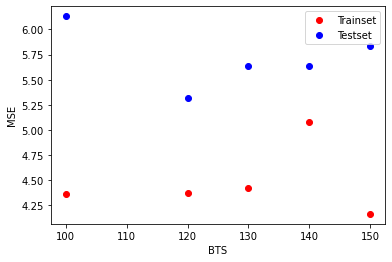

In [449]:
plt.plot(B,tr_vals,'or')
plt.plot(B,te_vals,'ob')
plt.xlabel("BTS")
plt.ylabel("MSE")
plt.legend(['Trainset','Testset'])